# Word Embeddings Introduction

Word embeddings are a type of word representation that allows words to be expressed as vectors in a continuous vector space. These vectors capture semantic menaings and relationshps between words bases on their usage in large text of corpora

## Import and Package installation

Let's install some important packages and libraries

In [1]:
!pip install --upgrade gensim
!pip install scikit-learn
!pip install matplotlib
!pip install datasets
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00


In [2]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4227136 sha256=a54fb68ffb4fa5237623bffd7428ec540df6206d644799cde8f6d82da79faae6
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


Let's import some useful libraries

In [3]:
from google.colab import drive
import os
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
from gensim.models import FastText, Word2Vec, KeyedVectors
import string
import numpy as np
import pandas as pd
from pandas.core.common import flatten
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from datasets import load_dataset
import re
import csv
import random
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import fasttext
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

## Setup

In [4]:
drive.mount('/content/drive')
os.chdir(f'/content/drive/MyDrive/Colab Notebooks/NLP/Assignment/datasets')
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks/NLP/Assignment/datasets'

Set to true **HUGGINGFACE** to download the dataset directly from HuggingFace

In [5]:
HUGGINGFACE = False

In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Utils

Define a dictionary of contractions and their expansions

In [8]:
contractions_dict = {
    "can't": "cannot",
    "won't": "will not",
    "I'm": "I am",
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "they're": "they are",
    "we're": "we are",
    "you're": "you are",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "I'll": "I will",
    "you'll": "you will",
    "he'll": "he will",
    "she'll": "she will",
    "we'll": "we will",
    "they'll": "they will",
    "I'd": "I would",
    "you'd": "you would",
    "he'd": "he would",
    "she'd": "she would",
    "we'd": "we would",
    "they'd": "they would",
    "there's": "there is",
    "here's": "here is",
    "how's": "how is",
    "let's": "let us",
    "that's": "that is",
    "what's": "what is",
    "who's": "who is",
    "where's": "where is",
    "why's": "why is",

}

The **expand_contractions** function is designed to expand contractions in a given text based on a provided dictionary of contractions and their corresponding expanded forms.

In [9]:
def expand_contractions(text, contractions_dict=contractions_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def replace(match):
        match_text = match.group(0)
        expanded_text = contractions_dict.get(match_text.lower())
        return expanded_text

    expanded_text = contractions_pattern.sub(replace, text)
    return expanded_text

The function **preprocess_document** is designed to process a given document, performing various optional text preprocessing steps based on the specified parameters. These parameters include:

* expand: If set to True, the function expands contractions in the document (e.g., "can't" to "cannot").
* isSorted: If set to True, the function sorts the processed document alphabetically.
* isSet: If set to True, the function converts the processed document into a set, removing any duplicate elements.
* noStopWords: If set to True, the function removes common English stopwords from the processed document.
* lemmatization: If set to True, the function lemmatizes the words in the processed document using WordNet.

The function begins by expand contractions, removing punctuation from the document using a regular expression. Then, depending on the parameters provided, it applies additional processing steps accordingly. Finally, it returns the processed document.

In [10]:
def preprocess_document(document, expand=False, noPunctuation=False, isSorted=False, isSet=False, noStopWords=False, lemmatization=False):
    newDocument = document
    if expand:
        newDocument = [expand_contractions(word) for word in newDocument]
    if noPunctuation:
        regex = '[' + string.punctuation + ']'
        newDocument = [re.sub(regex, '', item) for item in newDocument]
    if isSet:
        newDocument = set(newDocument)
    if noStopWords:
        newDocument = [w for w in newDocument if w not in stopwords.words('english')]
    if isSorted:
        newDocument = sorted(newDocument)
    if lemmatization:
        lemmatizer = WordNetLemmatizer()
        newDocument = [lemmatizer.lemmatize(w) for w in newDocument]
    return ' '.join(newDocument)

The upcoming snippet of code demonstrates how to use vector arithmetci with a pre-trained word embedding model to find terms semantically similar to a given concept given the vocabulary of the embedding.
This technique leverages the semantic relationships captured by the word embeddings to explore and understand the conceptual adjustments within the embedding space

In [11]:
def adjust_term_vector(model,term, term_to_adjust_from, term_to_adjust_to, topN=10):
  term_vec = model.get_vector(term)
  adjust_from_vec = model.get_vector(term_to_adjust_from)
  adjust_to_vec = model.get_vector(term_to_adjust_to)
  adjusted_vec = term_vec + (adjust_from_vec - adjust_to_vec)
  closest_terms = model.most_similar(adjusted_vec, topn=topN)
  return closest_terms

In [12]:
def plot_PCA_decomposition(model, words):
  words_vec = np.array([model[word] for word in words])
  pca = PCA(n_components=2)
  words_vec_2d = pca.fit_transform(words_vec)
  plt.figure(figsize=(7, 7))
  plt.scatter(words_vec_2d[:, 0], words_vec_2d[:, 1], edgecolors='k', c='g')
  for word, (x, y) in zip(words, words_vec_2d):
      plt.text(x, y, word, fontsize=12)
  plt.show()

# Dataset loading

**Basic Description of the Dataset and its Design**

The dataset in our study was derived from the Anki Medical Curriculum flashcards, a comprehensice collection curated and continually updated by medical students. Thes flashcards cover the full breadth of the medcial curriculum, encompassing subjects suche as anatomy, physiology, pathology and pharmacology. Each flashcard typically includes summaries to facilitate the learning and retention of key medical concepts. To create the dataset, the content was extracted from these flashcards, excluding those containing images.
Then, OpenAI's GPT 3.5- turbo was employed to transfrom the flashcard content into coherent, contextually relevant question-answer pairs.

The dataset consists of over 30,000 questions, each accompanied by a corresponding segment of text serving as its answer. Notably, these answers lack any additional context.



**Dataset Loading**

We initiate dataset download with this code snippet, offering flexibility in data retrieval. Depending on the value of the HUGGINGFACE flag, the script fetches the dataset from Hugging Face's repository or directly loads it from a CSV file stored on Google Drive. This versatile approach simplifies the process of acquiring the necessary data for analysis or modeling tasks.

## Huggining face loading

In [13]:
if HUGGINGFACE == True:
  raw_datasets =  load_dataset("medalpaca/medical_meadow_medical_flashcards", download_mode="force_redownload")
  raw_dataframe = raw_datasets['train'].to_pandas()
  raw_dataframe.to_csv('MedFlashCards.csv', index=False)


## Drive loading

In [14]:
if HUGGINGFACE == False:
  medFlashCards_dataframe = pd.read_csv('MedFlashCards.csv')

question_df = pd.read_csv('questions_dataframe.csv')
answer_df = pd.read_csv('answers_dataframe.csv')


# Learning word embeddings

## Data Preprocessing

Data preprocessing is crucial before training word embeddings because it ensures the text data is clean, consistent, and meaningful. Here's why each operation is important:


*   **Remove Punctuation and Special Characters**: Punctuation and special characters do not carry meaningful semantic information for word embeddings and can introduce noise. Removing them helps focus on the actual words and their relationships

*   **Expand Contractions**: Contractions like "can't" or "won't" are expanded to "cannot" and "will not" to standardize the text. This ensures that the model treats them as the same words rather than different tokens, improving the quality of embeddings

*  **Lowercase Words**: Converting all words to lowercase standardizes the text, so "Apple" and "apple" are treated as the same word. This reduces the vocabulary size and improves the embeddings' consistency.

*  **Lemmatization**: Lemmatization reduces words to their base or root form, such as converting "running" to "run." This helps in grouping similar words together, ensuring that the embeddings capture the core meaning rather than different forms of the same word.

By performing these preprocessing steps, the text data becomes cleaner and more uniform, allowing the word embeddings to capture more accurate and meaningful representations of the words.

In [47]:
train_questions = question_df['question'].apply(lambda question: preprocess_document(question.lower().split(), noPunctuation=True, expand=True, lemmatization=True ))
train_answers = answer_df['answer'].apply(lambda answer: preprocess_document(answer.lower().split(), noPunctuation=True, expand=True, lemmatization=True ))

First, we will train word embeddings using the Word2Vec implementation from the Gensim package

In [48]:
train_questions = list(flatten(train_questions))
train_answers = list(flatten(train_answers))

## Tokenization


In the upcoming code block, the tokenization process is performed. Tokenization involves splitting text into smaller units called tokens, which can be words, subwords, or characters. For word embeddings, this typically means breaking down a text into individual words or subwords that can then be converted into vectors.

In [49]:
train_questions_tokenized = [word_tokenize(question) for question in train_questions]
train_answers_tokenized = [word_tokenize(answer) for answer in train_answers]
tokenized_sentences = train_questions_tokenized + train_answers_tokenized

## Word2Vec

Word2Vec is a method for generating word embeddings by training a shallow neural network on a large corpus of text data. It learns dense vector representations of words based on their context, capturing semantic relationships between words. These embeddings are widely used in NLP tasks to measure semantic similarity and improve performance in various applications



Finally we have the data in the right format for training Word2Vec, so we can provide it to the algorithm. For parameters, we set:
- the embedding size to be 30,
- the minimum count for any vocabulary term to be 5
- the size of the context window to 10.

In [50]:
model = Word2Vec(tokenized_sentences, vector_size=30, min_count=5, window=10)

Let's see how big the vocabulary is that Word2Vec ended up using, i.e. how many word vectors did it learn:

In [51]:
num_vectors = len(model.wv)
print('Number of learned vectors: ', num_vectors)

Number of learned vectors:  12824


### Inspecting embeddings and finding similar words

Let's print out one of the vectors to see what looks like now that we have a word2vec model trained:

In [52]:
term = 'pregnancy'
model.wv[term]

array([ 0.984957  ,  1.3739016 , -2.4191678 ,  4.133384  , -0.6262379 ,
        4.0053144 , -2.171859  ,  1.5274634 , -1.3451711 ,  1.005634  ,
        8.982003  ,  5.5150785 ,  3.1384373 ,  6.410594  , -3.1742835 ,
       -5.5296335 , -0.3376467 , -2.5124896 , -0.8216255 ,  2.8813436 ,
       -1.6556225 , -2.6263    ,  0.66339594, -0.37167728, -4.672228  ,
       -4.867755  ,  0.60901535, -2.911126  ,  0.05925114,  4.121264  ],
      dtype=float32)

We could now use the model to compute similarities between terms based on their cosine distance in the embedding space.


In [53]:
term = 'heart'
model.wv.most_similar(term)

[('cardiac', 0.7828686833381653),
 ('pulmonary', 0.6891435980796814),
 ('stroke', 0.6551571488380432),
 ('left', 0.6438024640083313),
 ('ventricular', 0.6318501234054565),
 ('flow', 0.6295478940010071),
 ('cardiomyopathy', 0.6183631420135498),
 ('rvr', 0.6173581480979919),
 ('lung', 0.6118032932281494),
 ('arrhythmia', 0.6093399524688721)]

In [54]:
term = 'virus'
model.wv.most_similar(term)

[('human', 0.8375719785690308),
 ('animal', 0.82331782579422),
 ('viral', 0.8030317425727844),
 ('pathogen', 0.8018832206726074),
 ('member', 0.7666654586791992),
 ('malaria', 0.7534253597259521),
 ('herpesvirus', 0.7475161552429199),
 ('chickenpox', 0.7412557005882263),
 ('reservoir', 0.7403846979141235),
 ('transmission', 0.7320493459701538)]

In [55]:
term = 'antidepressant'
model.wv.most_similar(term)

[('antipsychotic', 0.9130872488021851),
 ('ssri', 0.9074057936668396),
 ('benzodiazepine', 0.9026447534561157),
 ('tcas', 0.8990811109542847),
 ('carbamazepine', 0.8914530277252197),
 ('tricyclic', 0.8811619281768799),
 ('olanzapine', 0.874509871006012),
 ('snris', 0.8686013221740723),
 ('secondgeneration', 0.8626098036766052),
 ('quetiapine', 0.8601287007331848)]

In [56]:
term = 'insulin'
model.wv.most_similar(term)

[('glucagon', 0.7963194847106934),
 ('cortisol', 0.7506731748580933),
 ('glucose', 0.7320610880851746),
 ('thyroxinebinding', 0.719237208366394),
 ('renin', 0.7127989530563354),
 ('estrogen', 0.7096562385559082),
 ('adh', 0.7006741762161255),
 ('ocp', 0.6998757719993591),
 ('catecholamine', 0.6993333101272583),
 ('aldosterone', 0.6939207315444946)]


The following snippet of code shows how a word's meaning shifts based on an analogy. Imagine insulin is the base word. We want its meaning to move away from diabetes and closer to pneumonia. The code uses a fancy method (PCA) to create a visual map where closer words have similar meaning

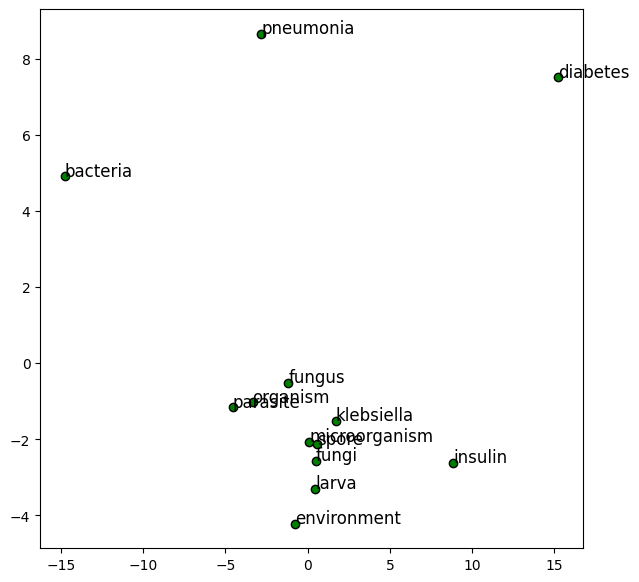

In [57]:
term_vec = 'insulin'
adjust_from_vec = 'pneumonia'
adjust_to_vec = 'diabetes'
closest_terms = adjust_term_vector(model.wv,term_vec, adjust_from_vec, adjust_to_vec)
words = [word[0] for word in closest_terms] + [term_vec, adjust_from_vec, adjust_to_vec]
plot_PCA_decomposition(model.wv, words)

### Visualising the embedding vectors using t-SNE

We'll now visualise some of the word vectors in a 3 dimensional space using t-SNE.
The vocabulary of word vectors is quite large (around 25,000). Giving them all to t-SNE will cause it to take far too long to converge. So let's first choose a random subset of 500 terms to show.

In [58]:
sample = random.sample(list(model.wv.key_to_index), 500)
print(sample)

['bonus', 'mmr', 'shortacting', 'laxative', 'prematurity', 'nitrosureas', 'tularensis', 'pde5', 'observing', 'mature', 'two', 'adrenaline', 'highlighting', '21hydroxylase', 'equal', 'orchiopexy', 'gubernaculum', 'twitch', 'silicosis', 'mostly', 'stsegment', 'mhcs', 'bothersome', 'gonad', 'pylorus', 'hp', 'perinatal', 'botryoides', 'catch', 'endocardium', 'splicing', 'latent', 'hydrocarbon', 'immunosorbent', 'epicondyle', 'intramuscularly', 'hiv', 'koplik', 'previously', 'shinedalgarno', 'carboxylase', 'innate', 'chemotherapyinduced', 'ironcontaining', 'spermatogenesis', 'nifedipine', 'toxin', 'purulent', 'odor', 'embolization', 'abducens', 'drowning', 'rolling', 'cholecystectomy', 'excrete', 'sobriety', 'reversibility', 'angioplasty', 'shortness', 'famciclovir', 'encephalopathy', 'dopa', 'term', 'displaying', 'interspersed', '11deoxycorticosterone', 'fibrous', 'dash', 'fit', 'thirdtrimester', 'reninangiotensinaldosterone', 'fastigial', 'agenesis', 'misfolded', 'resume', 'pm', 'deiodina

Now we'll get the word vectors for the sampled terms:

In [59]:
word_vectors = model.wv[sample]
word_vectors

array([[ 0.06685182, -0.19888394,  0.42301267, ...,  0.53433734,
        -0.01534741,  0.29816443],
       [-0.37866214,  0.17242959, -0.08695994, ...,  0.18164071,
         0.42173502, -0.10814668],
       [-0.41228393,  0.40014538,  0.09201097, ...,  0.12326173,
        -0.20069204,  0.12257712],
       ...,
       [ 0.10597809, -0.3704298 ,  0.60762995, ...,  0.88226527,
         1.1162413 ,  1.0589542 ],
       [-0.07905617,  0.06568398,  0.08211022, ...,  0.15095302,
        -0.08824655,  0.04065832],
       [-0.07243624, -0.15624072, -0.00841592, ...,  0.06018213,
         0.00741082,  0.02679538]], dtype=float32)

And we'll provide the vectors to TSNE to fit a model and transform the data to 3 dimensions:

In [60]:
tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)

Now transform the data into 3 columns (for x, y, and z):

In [61]:
x, y, z = np.transpose(tsne_embedding)

And generate the 3d plot:

In [62]:
fig = px.scatter_3d(x=x, y=y, z=z)
fig.update_traces(marker=dict(size=3,line=dict(width=2)))
fig.show()

Well that's a not a particularly interesting 3d plot!
- How about we label some of the points on the graph to see what words they correspond to:

In [63]:
fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

Let's extend the random set of terms with a set of colours to see if they cluster:

In [64]:
# Add some specific terms to sample:
colours = ['red','green','blue','orange','yellow','purple','pink','cream','brown','black','white','gray']

word_vectors = model.wv[colours+sample]

tsne = TSNE(n_components=3)
tsne_embedding = tsne.fit_transform(word_vectors)

x, y, z = np.transpose(tsne_embedding)

In [65]:
import plotly.express as px

r = (-200,200)
fig = px.scatter_3d(x=x, y=y, z=z, range_x=r, range_y=r, range_z=r, text=colours + [None] * 500)
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

Note: t-SNE is a stochastic algorithm, so run it a couple of times to see how the visualisation changes.

Have a play around with the visualisation to see whether other sets of terms cluster together.

# Loading Pre-trained Embedding

## Glove-wiki-Gigaword-200

Using GloVe embedddings pre-trained on the Wikipedia 2014 + Gigaword 5 dataset (glove-wiki-gigaword-200) can enhance the performance of question answering systems on our dataset. These embeddings are trained on an extensive corpus, capturing deep semantic and synactic nuances. This pretraining provides a wealth of linguistic knowledge. With 200 dimensions, GloVe embeddings achieve a balance between capturing intricate word relationships and maintaning computational efficiency.
Additionally, employing pretrained embeddings accelerates the training process, as the model starts with rich word representations instead of learning them from scratch. Consequently, glove-wiki-gigaword-200 is an effective, efficient, and practical choice for enhancing question-answering systems across various datasets.

**GloVe-Wiki-Gigaword 200 overview**:


*   **Algorithm**: GloVe which captures global word-word co-occurence statistics
*   **Training Data**: Wikipedia and Gigaword corpus
*   **Vector dimension**: 200-dimensional embeddings




In [ ]:
model_wiki = api.load('glove-wiki-gigaword-200')

[==================================================] 100.0% 252.1/252.1MB downloaded


Let's see how big the vocabulary:

In [ ]:
print('Vocabulary size of Wikipedia model: ', len(model_wiki))

Vocabulary size of Wikipedia model:  400000


### Inspecting embeddings and finding similar words

We could now use the model to compute similarities between terms based on their cosine distance in the embedding space

In [ ]:
term = 'virus'
model_wiki.most_similar(term)

[('h5n1', 0.8023861050605774),
 ('flu', 0.7961314916610718),
 ('influenza', 0.7852848172187805),
 ('viruses', 0.7826143503189087),
 ('infected', 0.7646056413650513),
 ('infection', 0.7565535306930542),
 ('avian', 0.736918032169342),
 ('disease', 0.7129627466201782),
 ('h1n1', 0.7127939462661743),
 ('hiv', 0.6872677206993103)]

This code demonstrates how a word's meaning shifts based on analogies using vector arithmetic, such as "king" to "queen" and "man" to "woman." While a pretrained model on a large open-domain corpus can effectively capture complex word relationships, it often struggles with domain-specific analogies, such as "insulin" to "antibiotics" and "diabetes" to "pneumonia." In the following sections, we will explore how using a domain-specific pretrained model can enhance our performance in these specialized contexts.

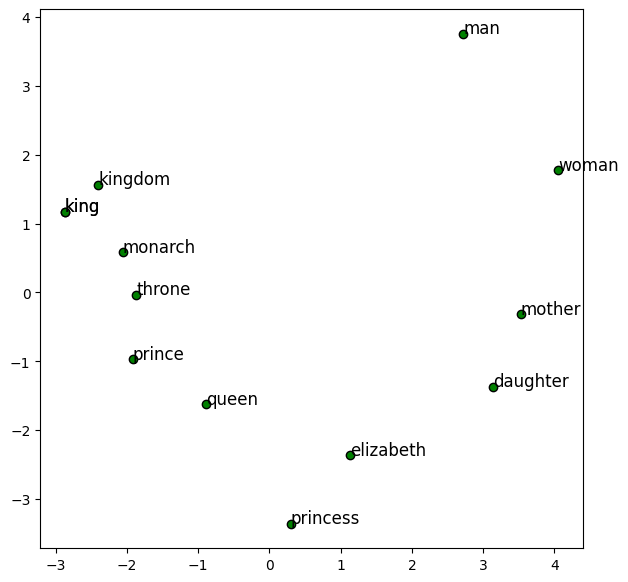

In [ ]:
term_vec = 'king'
adjust_from_vec = 'woman'
adjust_to_vec = 'man'
closest_terms = adjust_term_vector(model_wiki,term_vec, adjust_from_vec, adjust_to_vec)
words = [word[0] for word in closest_terms] + [term_vec, adjust_from_vec, adjust_to_vec]
plot_PCA_decomposition(model_wiki, words)

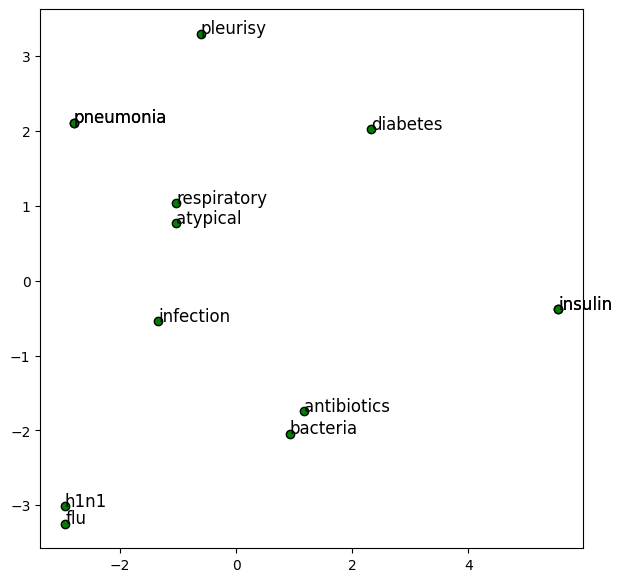

In [ ]:
term_vec = 'insulin'
adjust_from_vec = 'pneumonia'
adjust_to_vec = 'diabetes'
closest_terms = adjust_term_vector(model_wiki,term_vec, adjust_from_vec, adjust_to_vec)
words = [word[0] for word in closest_terms] + [term_vec, adjust_from_vec, adjust_to_vec]
plot_PCA_decomposition(model_wiki, words)

## Word2Ve - PMC - 100

Word embeddings create vector representations of text data, but not all embeddings effectively capture clinical, medical, and biomedical information. These embeddings provide a low-dimensional representation of semantic meaning, facilitating efficient text data analysis. While they are useful across various domains, their application to clinical, medical, and biomedical encounter notes presents several challenges. Commonly available pre-trained embeddings are often derived from broad, non-medical text sources, which may not accurately capture the specific word senses, linguistic relationships, or vocabulary needed in a clinical context. To address this, a training corpus based on clinical case reports from the PubMed Open Access subset is used. Consequently, a medical and biomedical pre-trained embedding model was employed.

**Word2Vec-PMC-Open-Access-All-Manuscripts overview**:


*   **Algorithm**: Word2Vec
*   **Training Data**: PMC Open Access All Manuscripts
*   **Vector dimension**: 100-dimensional embeddings

First download and extract the files from each archive

In [ ]:
!tar -xvf w2v_100d_oa_all.tar.gz

W2V_100/
W2V_100/w2v_oa_all_100d.bin
W2V_100/w2v_oa_all_100d.bin.wv.vectors.npy
W2V_100/w2v_oa_all_100d.bin.trainables.syn1neg.npy


In [ ]:
# Load the model
model = Word2Vec.load('W2V_100/w2v_oa_all_100d.bin')

Let's see how big the vocabulary:

In [ ]:
print(f'Size of the vocabulary: {len(model.wv)}')

Size of the vocabulary: 3748342


### Inspecting embeddings and finding similar words

Return 100-dimensional vector representations of each word

In [ ]:
term = 'diabetes'
model.wv.get_vector(term)

array([ 0.15587237, -0.21526715, -0.0323605 ,  0.76148087, -0.2782854 ,
        0.8411038 , -0.00650625,  0.23433806, -0.0761027 ,  0.00207981,
       -0.4543857 , -0.56023246,  0.19655031, -0.21839005, -0.10521119,
       -0.7835834 , -0.05072837, -0.39997765, -0.2998105 , -0.190565  ,
       -0.30767113, -0.22611964,  0.17512424,  0.6593262 ,  0.3139723 ,
        0.16817726, -0.12756337, -0.53831637,  0.03795823, -0.2157613 ,
        0.02385065, -0.19822836,  0.00516426,  0.34872437,  0.21584529,
       -0.8577351 , -0.26518902, -0.05431383,  0.13116212,  0.13011406,
        0.30474886,  0.7049852 ,  0.2902602 , -0.3332416 , -0.45113745,
       -0.38306913,  0.3473178 ,  0.27516854,  0.16708454,  0.2735584 ,
        0.3073361 , -0.14817624, -0.14050722,  0.13639155, -0.28233448,
        0.3174391 , -0.29256558,  0.5741609 , -0.29911152, -0.4043187 ,
       -0.13000344, -0.1936408 ,  0.18156712, -0.4930326 , -0.11364631,
        0.51986563,  0.5827516 , -0.37697923, -0.41214514,  0.03

In [ ]:
term = 'heart'
model.wv.get_vector(term)

array([ 0.06588871,  0.12963435, -0.20691247, -0.04423665,  0.2269309 ,
       -0.1364273 , -0.2530159 , -0.46485087, -0.25269625,  0.21392882,
       -0.3611834 , -0.23211358, -0.07592588, -0.13356479, -0.07205496,
       -0.05875115,  0.02730198, -0.18926473, -0.02287452,  0.03051401,
        0.20432356, -0.4618003 ,  0.1717871 ,  1.2867819 ,  0.17496017,
       -0.05106358,  0.4412725 , -0.38189805,  0.3641925 ,  0.09629215,
       -0.02156296, -0.16811883,  0.22350307, -0.0425162 ,  0.24586153,
        0.16713923,  0.1058826 ,  0.3592815 ,  0.42844045, -0.2738035 ,
        0.28339168,  0.608544  ,  0.04360754, -0.5102577 , -0.25942618,
       -0.04270536,  0.2818859 , -0.12827787,  0.0987231 ,  0.26725298,
        0.31250048, -0.13091503, -0.7226783 ,  0.5017468 , -0.77895266,
       -0.13317852, -0.19504613,  0.48210967, -0.25118834, -0.5074314 ,
        0.22008288,  0.0405115 ,  0.10661212, -0.18808636, -0.47916555,
       -0.25986305,  0.3770456 ,  0.06979397, -0.09745874, -0.29

In [ ]:
term = 'pregnancy'
model.wv.get_vector(term)

array([ 0.3876718 , -0.20554067,  0.26721066,  0.69642323, -0.16134037,
        0.024119  , -0.35052082, -0.5011512 ,  0.29278904, -0.20137186,
        0.02281141, -0.49786168,  0.2345551 , -0.038245  , -0.22293854,
       -0.4466118 , -0.24806397, -0.16740617, -0.30120847, -0.28024405,
        0.42478663, -0.29440525,  0.4368799 ,  0.7933079 ,  0.52552974,
        0.23457614, -0.2620688 , -0.5737377 , -0.38584918,  0.08757859,
       -0.17154208,  0.2440752 ,  0.10372306,  0.5634213 ,  0.03001689,
       -0.61334354, -0.21322027,  0.0246358 ,  0.3648225 ,  0.6584569 ,
        0.3274665 ,  0.47416034, -0.68190485, -0.28018704, -0.09199507,
        0.06139649,  0.460309  ,  0.08747132,  0.06840397, -0.3425311 ,
        0.18172355, -0.28496417, -0.08614258, -0.28894478, -0.3526635 ,
        0.19265857,  0.1440224 ,  0.70365477,  0.14854184, -0.33009183,
        0.26446   , -0.16543913,  0.4405985 , -0.3465345 ,  0.07069509,
       -0.2495602 ,  0.18496543, -0.17843227, -0.3146148 , -0.39

In [ ]:
model.wv.similarity('myocardial_infarction', 'heart_attack')

0.7921261

We could now use the model to compute similarities between terms based on their cosine distance in the embedding space.


In [ ]:
term = 'delirium'
model.wv.most_similar(term)

[('delirium,', 0.8845890760421753),
 ('delirium.', 0.8689318895339966),
 ('with_delirium', 0.8437003493309021),
 ('delirious', 0.8422060012817383),
 ('delirium_is', 0.8246074914932251),
 ('confusion_assessment_method', 0.8004822731018066),
 ('delirium:', 0.7930217981338501),
 ('delirium)', 0.7926177382469177),
 ('post-icu', 0.7756220698356628),
 ('bpsd', 0.7712751626968384)]

In [ ]:
term = 'heart'
model.wv.most_similar(term)

[('heart,', 0.8543963432312012),
 ('cardiac', 0.8119029402732849),
 ('left_ventricle', 0.8086162805557251),
 ('myocardium', 0.8016836047172546),
 ('heart.', 0.7923861145973206),
 ('left_ventricle,', 0.7900839447975159),
 ('heart_muscle', 0.7879527807235718),
 ('heart)', 0.787436842918396),
 ('myocardium,', 0.7868624329566956),
 ('human_heart', 0.7810763120651245)]

The upcoming snippet of code demonstrates how to use vector arithmetic for word's meaning shifts based on analogies with a pre-trained word embedding model - Word2Vec on PMC Open Access All Manuscripts - to find terms semantically similar to a given concept in the context of medical literature.
This technique leverages the semantic relationships captured by the word embeddings to explore and understand the conceptual adjustments within the embedding space

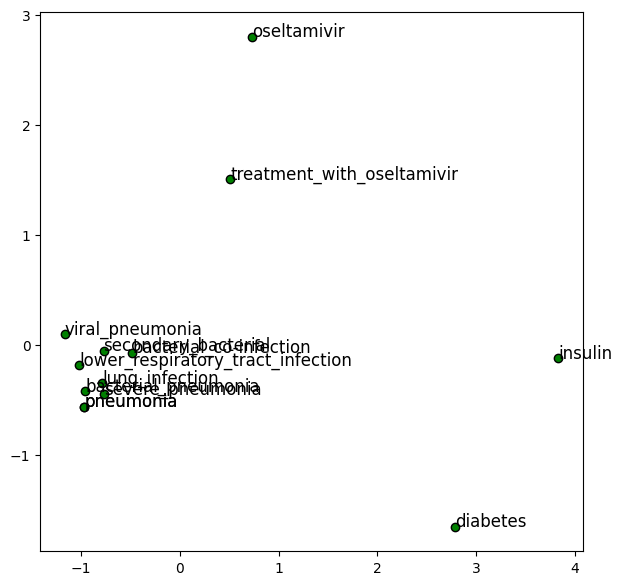

In [ ]:
term_vec = 'insulin'
adjust_from_vec = 'pneumonia'
adjust_to_vec = 'diabetes'
closest_terms = adjust_term_vector(model.wv,term_vec, adjust_from_vec, adjust_to_vec)
words = [word[0] for word in closest_terms] + [term_vec, adjust_from_vec, adjust_to_vec]
plot_PCA_decomposition(model.wv, words)

## FastText - Common Crawl + Wikipedia - 300

fasttext is an extension of the Word2Vec model developed by Facebook AI Research. Unlike traditional Word2Vec, which considers words as atomic units, fasttext trates words as a bags of character n-grams. This approach allows fasttext to generate embeddings for out-of-vocabulary words by aggregating embeddings of their character n-grams, enabling it to handle rare or misspelled words effectively.

In addition to word embeddings, fasttext also supports sentence embeddings. It achieves this by averaging the word embeddings within a sentence to create a fixed-size vector representation of the entire sentence.

**fasttext word vectors for 157 languages overview**:

**Algorithm**: fasttext

**Training Data**: Wikipedia + Commn Crawl

**Vector Dimension**: 300 - dimension embedding

Let's download the model

In [15]:
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.zip
!wget http://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gzip -d cc.en.300.bin.gz

--2024-05-26 16:40:56--  http://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.25, 13.226.210.111, 13.226.210.78, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.25|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  63.6MB/s    in 65s     

2024-05-26 16:42:02 (65.9 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



Let's load the model

In [16]:
ft_model = fasttext.load_model('cc.en.300.bin')

Let's see how big the vocabulary:

In [17]:
print(f'Size of the vocabulary: {len(ft_model.get_words())}')

Size of the vocabulary: 2000000


### Inspecting embeddings and finding similar words

Return 300-dimensional vector representations of each word

In [18]:
term = 'diabetes'
ft_model.get_word_vector(term)

array([ 2.66517308e-02, -5.50533133e-03,  4.03945819e-02,  1.43104354e-02,
        1.21714445e-02,  3.73507626e-02,  4.48851362e-02,  7.07524717e-02,
        2.45890114e-02,  2.06059497e-02,  1.02338297e-02, -5.28270043e-02,
       -6.69950247e-02,  3.72967520e-03, -2.40937155e-02,  3.21787829e-03,
        2.69589806e-03,  9.83766541e-02, -9.30464044e-02,  1.68398060e-02,
        7.36800628e-03, -4.16715484e-04, -1.34825185e-02, -3.56079042e-02,
        4.93054837e-03,  2.40103193e-02, -3.05536366e-03, -6.12371676e-02,
        3.45734060e-02,  1.39383614e-01, -3.07154208e-02,  4.38064821e-02,
        5.28979637e-02,  4.45477739e-02,  3.54307890e-02,  2.29135295e-03,
        5.38680255e-02,  8.94212276e-02,  1.57402717e-02, -8.25082790e-03,
       -3.86206098e-02, -1.71223935e-02, -4.24589328e-02,  1.06044553e-01,
       -4.80851568e-02, -7.52982870e-03,  4.24550707e-03, -8.85184680e-04,
        4.01175255e-03,  7.41799921e-02,  5.57622388e-02, -5.69444615e-03,
        7.69035378e-03,  

In [19]:
term = 'heart'
ft_model.get_word_vector(term)

array([-0.01069687,  0.00749084,  0.02658757,  0.08114164,  0.00507168,
        0.03323174,  0.08663563,  0.08131171,  0.09383441,  0.02778573,
       -0.00543579, -0.05585865,  0.01987327, -0.12310187, -0.03052635,
        0.04407067, -0.03413357,  0.09878649, -0.20513429, -0.05951565,
        0.03060767,  0.09329603, -0.03385869,  0.0049211 , -0.00108816,
       -0.05336034,  0.03967582, -0.04687127,  0.00691536,  0.08799434,
        0.12510814, -0.01051231,  0.16750033,  0.02693585, -0.01639322,
       -0.04386955,  0.04636188,  0.14046961,  0.01264571, -0.00268973,
       -0.05757606,  0.00845254,  0.04046905,  0.09134136, -0.09754813,
        0.04426818,  0.03492715,  0.00722999, -0.03034792, -0.08284545,
        0.00531217,  0.01574977,  0.01269341, -0.05081033, -0.0430023 ,
        0.02883614, -0.06163967,  0.07236434, -0.0622297 ,  0.02622898,
       -0.03778183, -0.07362685, -0.04476019,  0.03067518,  0.07378238,
        0.04446434,  0.08590045, -0.04797767, -0.07052004, -0.00

In [20]:
term = 'pregnancy'
ft_model.get_word_vector(term)

array([ 0.06442159,  0.02849412, -0.00520854,  0.04224534,  0.05890721,
       -0.04647874,  0.01002928, -0.02467275,  0.06080916,  0.05822769,
       -0.02710035, -0.03775091, -0.00375833,  0.02707931,  0.04183507,
        0.05073382, -0.03351288, -0.04378466, -0.11219592,  0.02444251,
        0.02523908,  0.00695075, -0.01619829, -0.02438295,  0.00566483,
        0.02317011, -0.07134087, -0.00373496,  0.03818878,  0.10423173,
       -0.0502831 , -0.01841491, -0.02388978, -0.06568521,  0.0122    ,
        0.08329898,  0.034153  ,  0.03493753,  0.0022857 , -0.04755963,
        0.03096193, -0.06505139, -0.03324492,  0.09713449, -0.04061525,
        0.00943033,  0.05685892, -0.02212619,  0.03745135, -0.034743  ,
       -0.01422575,  0.02575282, -0.01006156,  0.08419409,  0.02080684,
        0.00757581,  0.08128425,  0.02001539, -0.06189586,  0.04002463,
       -0.03414609, -0.0912771 , -0.01986078,  0.03634254,  0.03533482,
        0.03762887,  0.07031051, -0.02080228,  0.00264135, -0.02

We could now use the model to compute similarities between terms based on their cosine distance in the embedding space.


In [21]:
term = 'delirium'
ft_model.get_nearest_neighbors(term)

[(0.7114084362983704, 'delerium'),
 (0.7077973484992981, 'delirious'),
 (0.6776441931724548, 'deliriums'),
 (0.6257109045982361, 'tremens'),
 (0.6234448552131653, 'psychosis'),
 (0.6052219867706299, 'catatonia'),
 (0.5902892351150513, 'confusional'),
 (0.5834601521492004, 'convulsions'),
 (0.5795432329177856, 'giddiness'),
 (0.5795360207557678, 'stuporous')]

In [22]:
term = 'heart'
ft_model.get_nearest_neighbors(term)

[(0.6940825581550598, 'heart.The'),
 (0.6627554893493652, 'heart.So'),
 (0.6598211526870728, 'heart-'),
 (0.6592054963111877, 'heart.This'),
 (0.6467713713645935, 'heart.It'),
 (0.640329897403717, 'hearts'),
 (0.6396079063415527, 'heart.If'),
 (0.6350721120834351, 'heart.I'),
 (0.6320149898529053, 'heart.When'),
 (0.6282981634140015, 'heart.But')]

The upcoming snippet of code demonstrates how to use vector arithmetic for word's meaning shifts based on analogies with a pre-trained word embedding model

In [32]:
term_vec = 'king'
adjust_from_vec = 'woman'
adjust_to_vec = 'man'

closest_terms = ft_model.get_analogies(adjust_from_vec, adjust_to_vec, term_vec)
closest_terms

[(0.7554811835289001, 'queen'),
 (0.6141632795333862, 'queen-mother'),
 (0.5755330920219421, 'princess'),
 (0.5741076469421387, 'monarch'),
 (0.5688968300819397, 'kings'),
 (0.5649929046630859, 'queenship'),
 (0.5638618469238281, 'Queen'),
 (0.5544734597206116, 'empress'),
 (0.5524800419807434, 'consort'),
 (0.5497491955757141, 'queen.The')]

Let's combine the retrived words with the ones used to retrive them

In [38]:
words = [word[1] for word in closest_terms] + [term_vec, adjust_from_vec, adjust_to_vec]

In [39]:
words

['queen',
 'queen-mother',
 'princess',
 'monarch',
 'kings',
 'queenship',
 'Queen',
 'empress',
 'consort',
 'queen.The',
 'king',
 'woman',
 'man']

Let's plot the embeddings in the 2D space using PCA

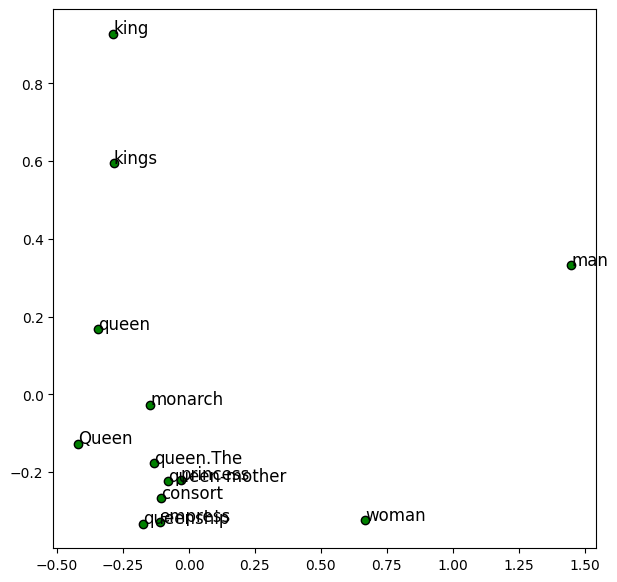

In [40]:
words_vec = np.array([ft_model.get_word_vector(word) for word in words])
pca = PCA(n_components=2)
words_vec_2d = pca.fit_transform(words_vec)
plt.figure(figsize=(7, 7))
plt.scatter(words_vec_2d[:, 0], words_vec_2d[:, 1], edgecolors='k', c='g')
for word, (x, y) in zip(words, words_vec_2d):
    plt.text(x, y, word, fontsize=12)
plt.show()

In [43]:
term_vec = 'insulin'
adjust_from_vec = 'pneumonia'
adjust_to_vec = 'diabetes'

closest_terms = ft_model.get_analogies(adjust_from_vec,adjust_to_vec,term_vec)

In [44]:
words = [word[1] for word in closest_terms] + [term_vec, adjust_from_vec, adjust_to_vec]

In [45]:
words

['pnuemonia',
 'Pneumonia',
 'antibiotic',
 'pnemonia',
 'antiobiotic',
 'bronchopneumonia',
 'pneumonias',
 'antibiotics',
 'bronchitis',
 'peritonitis',
 'insulin',
 'pneumonia',
 'diabetes']

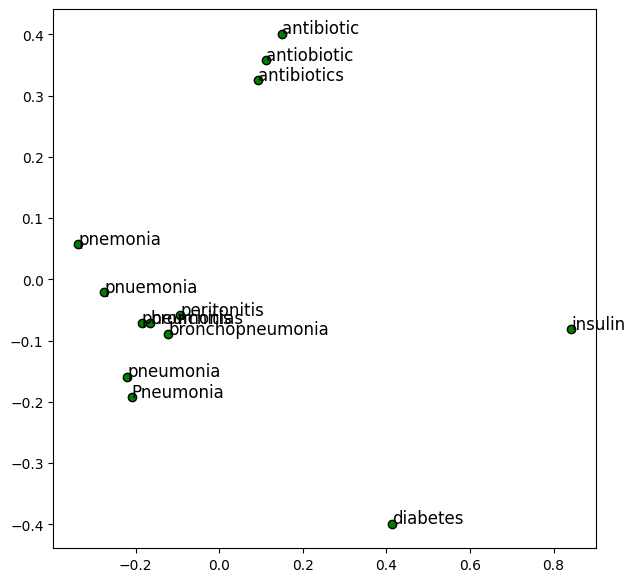

In [46]:
words_vec = np.array([ft_model.get_word_vector(word) for word in words])
pca = PCA(n_components=2)
words_vec_2d = pca.fit_transform(words_vec)
plt.figure(figsize=(7, 7))
plt.scatter(words_vec_2d[:, 0], words_vec_2d[:, 1], edgecolors='k', c='g')
for word, (x, y) in zip(words, words_vec_2d):
    plt.text(x, y, word, fontsize=12)
plt.show()

In the upcoming line of code, we compute the embeddings for the first 100 questions of the dataset using the FastText model

In [66]:
word_vectors_questions = np.array([ft_model.get_word_vector(doc) for doc in question_df['question'][:100] ])

Let's proceed to compute the distance matrix of the vector embeddings for the first 100 questions. Subsequently, we'll visualize the similarity matrix using a heatmap. Heatmapes depicting distance metrics offer valuable insights into the similarities between elements and can aid in rudimentary clustering, identifying similar elements within the dataset

In [67]:
distance_matrix = squareform(pdist(word_vectors_questions, metric='cosine'))
plt.figure(figsize=(100, 100))
sns.heatmap(1 - distance_matrix[:100, :100], annot=True, cmap='coolwarm', square=True)
plt.show()

The same can be done for the first 100 answers

In [68]:
word_vectors_answers = np.array([ft_model.get_word_vector(doc) for doc in answer_df['answer'][:100] ])

In [71]:
distance_matrix = squareform(pdist(word_vectors_answers, metric='cosine'))
plt.figure(figsize=(100, 100))
sns.heatmap(1 - distance_matrix[:100, :100], annot=True, cmap='coolwarm', square=True)
plt.show()

By inspecting the heatmap and manually examing the dataset, it becomes evident that there are many similar questions within the dataset. The heatmap reveals clusters of  closely related answers through regions of similar colors, indicating high similarity, Moreover, performing clustering on the dataset could further confirm and identify these groups of similar questions more systematically

 While this approach may not be as sophisticated as more advanced clustering algorithms, it can provide useful initial insights into the structure of the data and potential groupings of similar elements.

##Conclusions

The analysis clearly demonstrates that utilizing pre-trained word embedding models leads to enhanced performance. One compelling analysis underscoring this advantage is the word analogy test (within the medical domain). It vividly illutrastes that pre-trained models talilored to specific domains consistently outperform their conterparts